In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
from scipy.stats import weibull_min

In [4]:
def weibull_dist(lam, k):
    return weibull_min(k, scale=lam)

In [5]:
# Weibull example

lam = 3
k = 0.8
actual_dist = weibull_dist(lam, k)

<Axes: title={'center': 'CDF of a Weibull Distribution'}, xlabel='Time Duration', ylabel='CDF'>

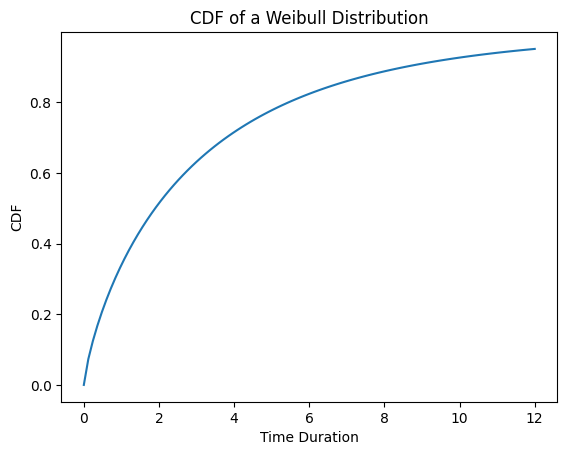

In [7]:
# Some steps are needed to graph this function

from empiricaldist import Cdf

qs = np.linspace(0, 12, 101)
ps = actual_dist.cdf(qs)
cdf = Cdf(ps, qs)

cdf.plot(title='CDF of a Weibull Distribution', xlabel='Time Duration', ylabel='CDF')

In [8]:
# We have a method rvs, which can be used to generate a random sample from a Weibull distribution

data = actual_dist.rvs(10)
data

array([4.9058302 , 0.58745622, 0.50196755, 2.14322905, 1.66196305,
       0.87367394, 0.59434744, 0.36647348, 0.95559171, 0.14630018])

In [9]:
# Given the parameters we can generate a sample
# But can we generate a distribution given a sample?

from empiricaldist import Pmf

def make_uniform(qs, name=None, **options):
    """Make a Pmf that represents a uniform distribution."""
    pmf = Pmf(1.0, qs, **options)
    pmf.normalize()
    if name:
        pmf.index.name = name
    return pmf

In [10]:
# Create uniform prior for lambda

lams = np.linspace(0.1, 10.1, num=101)
prior_lam = make_uniform(lams, name='lambda')

# And a uniform prior for k

ks = np.linspace(0.1, 5.1, num=101)
prior_k = make_uniform(ks, name='k')

In [11]:
def make_joint(pmf1, pmf2):
    """Compute the outer product of two Pmfs."""
    X, Y = np.meshgrid(pmf1, pmf2)
    return pd.DataFrame(X * Y, columns=pmf1.qs, index=pmf2.qs)

In [12]:
prior = make_joint(prior_lam, prior_k)

In [13]:
# Then, as before, use meshgrid to make a 3D mesh with lambda on axis 0, k on axis 1, and the data on axis 2

lam_mesh, k_mesh, data_mesh = np.meshgrid(prior.columns, prior.index, data)

# Then use weibull_dist to compute the PDF of the Weibull for each pair of parameters and each data point

densities = weibull_dist(lam_mesh, k_mesh).pdf(data_mesh)

In [14]:
densities.shape

(101, 101, 10)

In [15]:
# The likelihood of the data is the product of the probability densities along axis 2

likelihood = densities.prod(axis=2)
likelihood.sum()

np.float64(0.0005844348385080478)

In [16]:
def normalize(joint):
    """Normalize a joint distribution."""
    prob_data = joint.to_numpy().sum()
    joint /= prob_data
    return prob_data

In [17]:
posterior = prior * likelihood
normalize(posterior)

np.float64(5.7291916332521115e-08)

In [18]:
# These steps can be encapsulated in a function

def update_weibull(prior, data):
    """Update Weibull prior based on data"""
    lam_mesh, k_mesh, data_mesh = np.meshgrid(prior.columns, prior.index, data)
    
    densities = weibull_dist(lam_mesh, k_mesh).pdf(data_mesh)
    likelihood = densities.prod(axis=2)
    
    posterior = prior * likelihood
    normalize(posterior)
    
    return posterior

In [19]:
# In use

posterior = update_weibull(prior, data)

In [38]:
def plot_contour(joint):
    """Plot a joint distribution with a contour."""
    plt.contour(joint.columns, joint.index, joint,
                linewidths=2)
    plt.xlabel('lambda')
    plt.ylabel('k')
    plt.title('Posterior joint distribution of Weibull parameters')

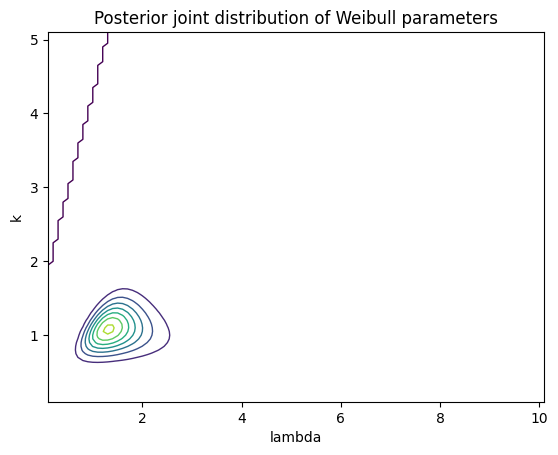

In [39]:
plot_contour(posterior)

In [22]:
# Example - suppose a dog shelter is interested in the time between a dog's arrival and adoption
# We monitor over 8 weeks, and 10 dogs arrive during the interval
# Assume that their arrival times are distributed uniformly

start = np.random.uniform(0, 8, size=10)
start

array([0.05697565, 7.5700243 , 7.52739205, 7.46618833, 2.6049297 ,
       0.1113921 , 1.34567448, 7.03598362, 5.16885971, 3.23149265])

In [23]:
# Suppose the residence times follow the Weibull from the previous example

duration = actual_dist.rvs(10)
duration

array([ 0.13030603,  0.85403173,  0.07429178,  1.5567691 ,  4.2566595 ,
        1.67803453,  3.6238139 ,  0.92359661,  1.18644561, 11.46095121])

In [26]:
# These values can be used to create a DataFrame with the arrival and departure times for each dog, called start and end

d = dict(start=start, end=start+duration)
obs = pd.DataFrame(d)

In [27]:
obs = obs.sort_values(by='start', ignore_index=True)
obs

,start,end
0,0.056976,0.187282
1,0.111392,1.789427
2,1.345674,4.969488
3,2.604930,6.861589
4,3.231493,14.692444
5,5.168860,6.355305
6,7.035984,7.959580
7,7.466188,9.022957
8,7.527392,7.601684
9,7.570024,8.424056


In [28]:
# If we collect our data at week 8, adoption dates for those adopted later than that will be censored

censored = obs['end'] > 8

In [29]:
# Then we modify end to indicated where these are last observed

obs.loc[censored, 'end'] = 8
obs.loc[censored, 'status'] = 0

In [30]:
# Then we can plot a "lifeline" for each dog

def plot_lifelines(obs):
    """Plot a line for each observation.
    
    obs: DataFrame
    """
    for y, row in obs.iterrows():
        start = row['start']
        end = row['end']
        status = row['status']
        
        if status == 0:
            # ongoing
            plt.hlines(y, start, end, color='C0')
        else:
            # complete
            plt.hlines(y, start, end, color='C1')
            plt.plot(end, y, marker='o', color='C1')
            
    plt.xlabel('Time (weeks)')
    plt.ylabel('Dog index')
    plt.title('Lifelines showing censored and uncensored observations')

    plt.gca().invert_yaxis()

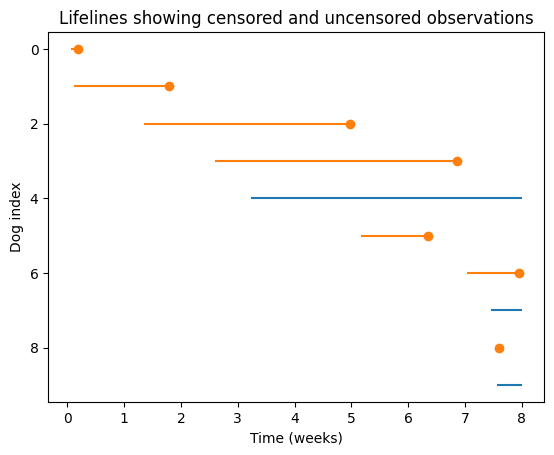

In [31]:
plot_lifelines(obs)

In [32]:
# One more column, containing the observed parts of the lifelines
# This is the data that would be available at the end of week 8

obs['T'] = obs['end'] - obs['start']

In [33]:
# We 1st split the data into 2 sets, for complete and incomplete

data1 = obs.loc[~censored, 'T']
data2 = obs.loc[censored, 'T']

In [34]:
posterior1 = update_weibull(prior, data1)

In [35]:
# The update for the incomplete data is more challenging. We don't know what the residence time will be for these dogs.
# We can put a lower bound on it
# That is we can compute the likelihood of the data with the survival function:
# it is the probability that a value from the distribution exceeds T

def update_weibull_incomplete(prior, data):
    """Update the Weibull prior using incomplete data"""
    lam_mesh, k_mesh, data_mesh = np.meshgrid(prior.columns, prior.index, data)
    
    probs = weibull_dist(lam_mesh, k_mesh).sf(data_mesh) # evaluating the survival function
    likelihood = probs.prod(axis=2)
    
    posterior = prior * likelihood
    normalize(posterior)
    return posterior

In [36]:
# The update with the incomplete data

posterior2 = update_weibull_incomplete(posterior1, data2)

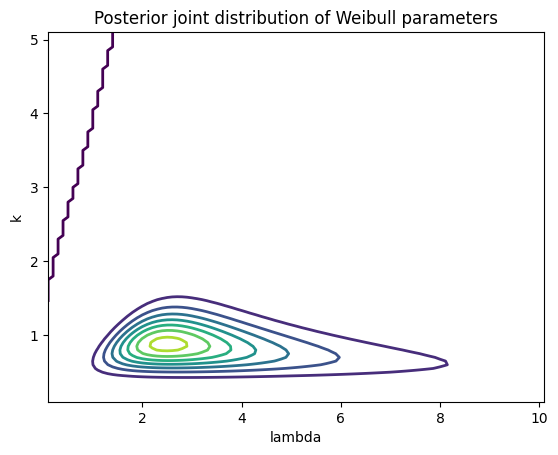

In [37]:
plot_contour(posterior2)

In [41]:
def marginal(joint, axis):
    """Compute a marginal distribution."""
    return Pmf(joint.sum(axis=axis))

In [42]:
posterior_lam2 = marginal(posterior2, 0)
posterior_k2 = marginal(posterior2, 1)

In [43]:
posterior_lam = marginal(posterior, 0)
posterior_k = marginal(posterior, 1)

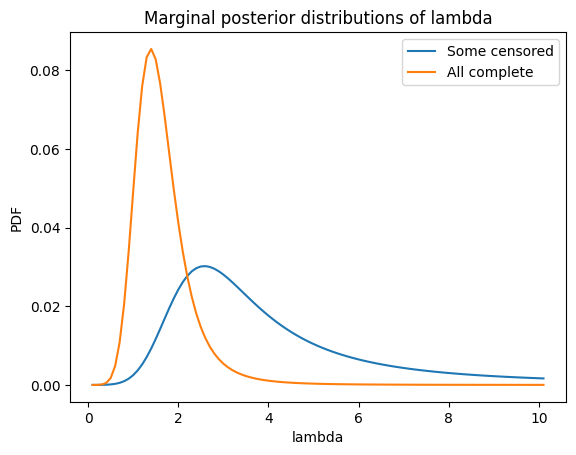

In [45]:
posterior_lam2.plot(label='Some censored', title='Marginal posterior distributions of lambda')
posterior_lam.plot(label='All complete', xlabel='lambda', ylabel='PDF')
plt.legend()

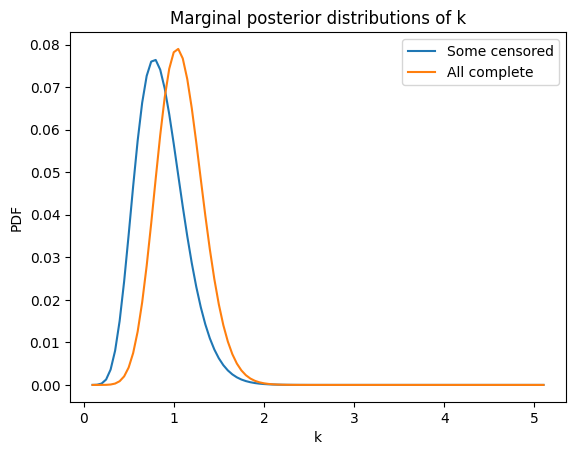

In [46]:
posterior_k2.plot(label='Some censored', title='Marginal posterior distributions of k')
posterior_k.plot(label='All complete', xlabel='k', ylabel='PDF')
plt.legend()

In [47]:
# In general the posteriors are wider when we have incomplete data, because this leads to more uncertainty

In [48]:
# Light bulb data example

df = pd.read_csv('https://gist.githubusercontent.com/epogrebnyak/7933e16c0ad215742c4c104be4fbdeb1/raw/c932bc5b6aa6317770c4cbf43eb591511fec08f9/lamps.csv?raw=true', index_col=0)
df.head()

,h,f,K
i,,,
0,0,0,50
1,840,2,48
2,852,1,47
3,936,1,46
4,960,1,45


In [49]:
# h contains the times (hours) when bulbs failed
# f contains the number of bulbs that failed at each time

from empiricaldist import Pmf

In [50]:
pmf_bulb = Pmf(df['f'].to_numpy(), df['h'])
pmf_bulb.normalize()

np.int64(50)

In [51]:
# We assume that the data are a representative sample from the distribution of bulb lifetimes
# Then estimate parameters that fit the data assuming a Weibull distribution
# Start with uniform prior for lambda and k

lams = np.linspace(1000, 2000, num=51)
prior_lam = make_uniform(lams, name='lambda')
ks = np.linspace(1, 10, num=51)
prior_k = make_uniform(ks, name='k')

In [52]:
# Only 51 values in the priors, because the posteriors are computationally intensive. They will be less precise.

prior_bulb = make_joint(prior_lam, prior_k)

# There are only data for 32 unique lifetimes
# For the update it's convenient to express the data in the form of 50 lifetimes, with each representing the 
# given number of times.

data_bulb = np.repeat(df['h'], df['f'])
len(data_bulb)

50

In [53]:
posterior_bulb = update_weibull(prior_bulb, data_bulb)

Text(0.5, 1.0, 'Posterior joint distribution, light bulbs')

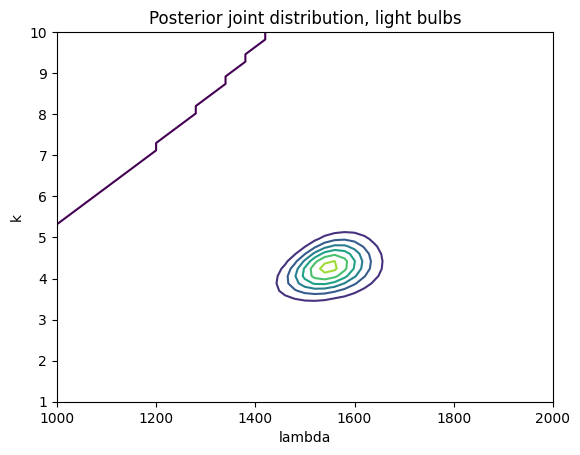

In [57]:
plt.contour(posterior_bulb.columns, posterior_bulb.index, posterior_bulb, linewidths=2)
plt.xlabel('lambda')
plt.ylabel('k')
plt.title('Posterior joint distribution, light bulbs')

In [58]:
# Summarize the posterior distribution

lam_mesh, k_mesh = np.meshgrid(prior_bulb.columns, prior_bulb.index)

means = weibull_dist(lam_mesh, k_mesh).mean()
means.shape

(51, 51)

In [59]:
# Weight each mean with the corresponding probability from the posterior

prod = means * posterior_bulb

# And then compute the sum of the weighted means

prod.to_numpy().sum() # So the mean lifetime of a bulb is about 1413 hours

np.float64(1412.7242774305005)

In [60]:
# A function encapsulating these steps

def joint_weibull_mean(joint):
    """Compute the mean of a joint distribution of Weibulls"""
    lam_mesh, k_mesh = np.meshgrid(joint.columns, joint.index)
    means = weibull_dist(lam_mesh, k_mesh).mean()
    prod = means * joint
    return prod.to_numpy().sum()

In [61]:
# From the online solution, this update isn't quite right, because the study only checked the bulbs every 12 hrs
# It's more correct to use the CDF of the Weibull to get the probability that the bulb dies in a 12-hr interval

def update_weibull_between(prior, data, dt=12):
    """Update the prior based on data."""
    lam_mesh, k_mesh, data_mesh = np.meshgrid(
        prior.columns, prior.index, data)
    dist = weibull_dist(lam_mesh, k_mesh)
    cdf1 = dist.cdf(data_mesh)
    cdf2 = dist.cdf(data_mesh-12)
    likelihood = (cdf1 - cdf2).prod(axis=2)

    posterior = prior * likelihood
    normalize(posterior)

    return posterior

In [62]:
# How we run the update

posterior_bulb2 = update_weibull_between(prior_bulb, data_bulb)

# This looks a lot like the result with the PDF, suggesting it's a good approximation

Text(0.5, 1.0, 'Posterior joint distribution, light bulbs')

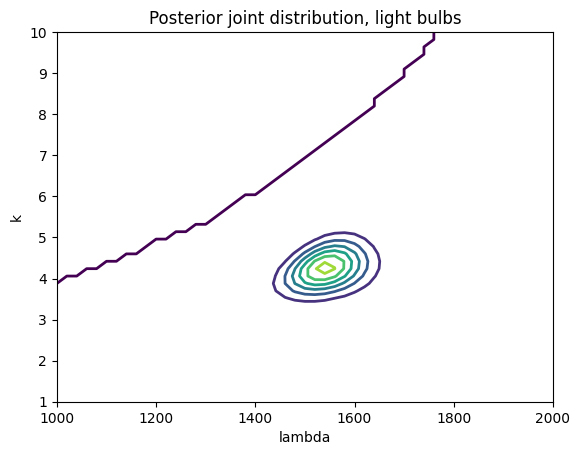

In [63]:
plt.contour(posterior_bulb2.columns, posterior_bulb2.index, posterior_bulb2, linewidths=2)
plt.xlabel('lambda')
plt.ylabel('k')
plt.title('Posterior joint distribution, light bulbs')

In [64]:
# Suppose we install 100 bulbs, and check on them after 1000 hours
# Based on the posterior, what is the distribution of the number of dead bulbs?

# If we knew the Weibull parameters, the answer would be a binomial distribution. EG:

lam = 1550
k = 4.25
t = 1000

prob_dead = weibull_dist(lam, k).cdf(t)
prob_dead

np.float64(0.14381685899960547)

In [65]:
def make_binomial(n, p):
    """Make a binomial Pmf."""
    ks = np.arange(n+1)
    ps = binom.pmf(ks, n, p)
    return Pmf(ps, ks)

In [67]:
from scipy.stats import binom

n = 100
p = prob_dead
dist_num_dead = make_binomial(n, p)

In [68]:
# But we don't know the Weibull parameters. So the posterior predictive distribution is a mixture of binomials
# weighted with the posterior probabilities
# We can use make_mixture, though this doesn't work wth joint distributions, so we convert the DataFrame to a Series

posterior_series = posterior_bulb.stack()
posterior_series.head()

1.0  1000.0    8.146763e-25
     1020.0    1.210486e-24
     1040.0    1.738327e-24
     1060.0    2.418201e-24
     1080.0    3.265549e-24
dtype: float64

In [69]:
# This is a series with 2 levels, one is the values of k, the other is the values of lambda
# With the posterior in this form, we can iterate through the possible parameters and compute a predictive
# distribution for each pair

pmf_seq = []
for (k, lam) in posterior_series.index:
    prob_dead = weibull_dist(lam, k).cdf(t)
    pmf = make_binomial(n, prob_dead)
    pmf_seq.append(pmf)

In [70]:
def make_mixture(pmf, pmf_seq):
    """Make a mixture of distributions."""
    df = pd.DataFrame(pmf_seq).fillna(0).transpose()
    df *= np.array(pmf)
    total = df.sum(axis=1)
    return Pmf(total)

In [71]:
post_pred = make_mixture(posterior_series, pmf_seq)

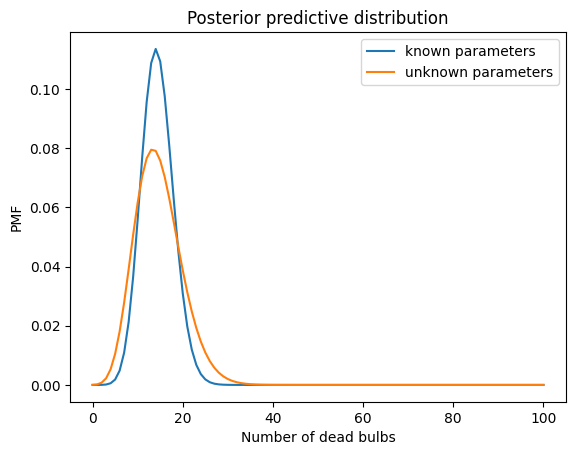

In [72]:
dist_num_dead.plot(label='known parameters', title='Posterior predictive distribution')
post_pred.plot(label='unknown parameters', xlabel='Number of dead bulbs', ylabel='PMF')
plt.legend()

In [73]:
# Exercise 14-1
# Suppose we do the light bulb experiment: install 100 bulbs, come back after 1000 hours, find 20 dead bulbs
# Update the posterior based on this. What does it do to the mean?

# The solution suggests using a meshgrid to compute the probability of finding a bulb dead after 1000 hours,
# for every pair of parameter values
# For each of those probabilities, compute the likelihood of 20 dead bulbs out of 100

t = 1000

lam_mesh, k_mesh = np.meshgrid(prior_bulb.columns, prior_bulb.index)
prob_dead = weibull_dist(lam_mesh, k_mesh).cdf(t)
prob_dead.shape

(51, 51)

In [74]:
k = 20
n = 100
likelihood = binom(n, prob_dead).pmf(k)
likelihood.shape

(51, 51)

In [75]:
posterior_bulb3 = posterior_bulb * likelihood
normalize(posterior_bulb3)

np.float64(0.03875611894207612)

Text(0.5, 1.0, 'Joint posterior distribution with k=20')

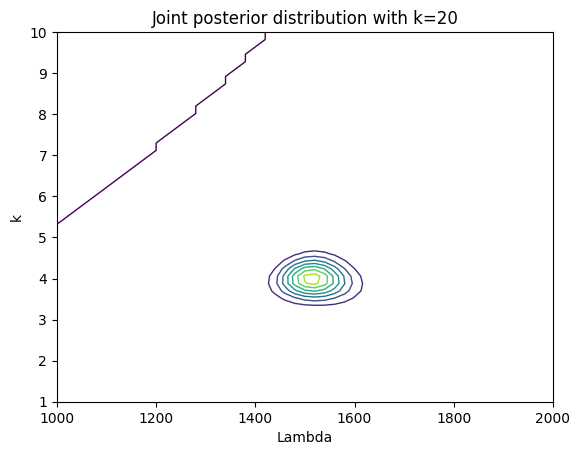

In [76]:
plot_contour(posterior_bulb3)
plt.xlabel('Lambda')
plt.ylabel('k')
plt.title('Joint posterior distribution with k=20')

In [77]:
joint_weibull_mean(posterior_bulb3) # There were more dead bulbs than expected, so the posterior mean is lower

np.float64(1378.3949572816407)

In [78]:
# Exercise 14-2 - 1 month of data to estimate daily rainfall in Seattle
# Then use the posterior to estimate the probability of a rare rain event (1.5in rain in a day)
# Total daily rainfall distribution (days with rain) is modeled by a 2-parameter gamma dist
# For the gamma, k is the shape parameter, theta is the scale parameter

# Make priors for k and theta. They must be > 0
# Use the observed rainfalls to update the parameters' distributions
# Compute the posterior predictive distribution, and use it to estimate Pr > 1.5 in

import scipy.stats

# This function is given by the solution

def gamma_dist(k, theta):
    """Makes a gamma object.
    
    k: shape parameter
    theta: scale parameter
    
    returns: gamma object
    """
    return scipy.stats.gamma(k, scale=theta)

In [79]:
# This is not even in the book, in case I feel guilty about going right to the solution

weather = pd.read_csv("https://github.com/AllenDowney/ThinkBayes2/raw/master/data/2203951.csv?raw=true")
weather.head()

,STATION,NAME,DATE,AWND,PRCP,TMAX,TMIN,WT01,WT03,WT08
0,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2020-05-01,4.47,0.00,66,43,NaN,NaN,NaN
1,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2020-05-02,9.40,0.24,58,47,1.0,NaN,NaN
2,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2020-05-03,11.63,0.06,57,44,1.0,NaN,NaN
3,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2020-05-04,4.47,0.00,65,39,NaN,NaN,NaN
4,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2020-05-05,7.83,0.00,71,49,NaN,NaN,NaN


In [80]:
# Create a Boolean series to indicate which days it rained on

rained = weather['PRCP'] > 0
rained.sum()

np.int64(14)

In [81]:
# And then select total rainfall on days it rained

prcp = weather.loc[rained, 'PRCP']
prcp.describe()

count    14.000000
mean      0.222857
std       0.301060
min       0.010000
25%       0.052500
50%       0.110000
75%       0.225000
max       1.140000
Name: PRCP, dtype: float64

<Axes: title={'center': 'Distribution of rainfall on days it rained'}, xlabel='Rainfall (in)', ylabel='CDF'>

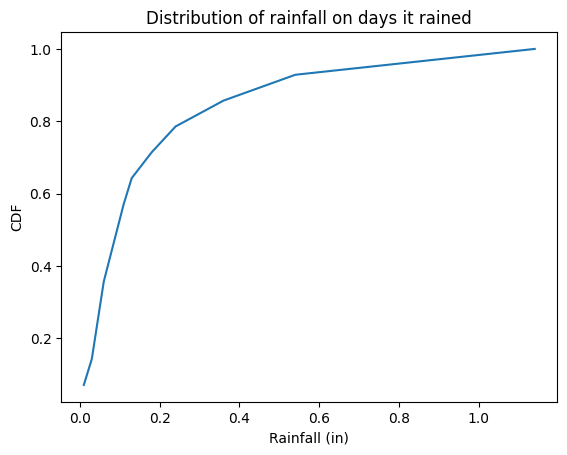

In [82]:
cdf_data = Cdf.from_seq(prcp)
cdf_data.plot(title='Distribution of rainfall on days it rained', xlabel='Rainfall (in)', ylabel='CDF')

In [83]:
# The max daily rainfall is 1.14 in, so we'll need to extrapolate from the data
# The quality of our estimate will depend on how good an approximation the gamma is

# For the priors, the solution uses the gamma's maximum likelihood parameters

k_est, _, theta_est = scipy.stats.gamma.fit(prcp, floc=0)
k_est, theta_est

(0.8898876017525283, np.float64(0.25043291132301665))

In [84]:
# Uniform priors for the parameters, upper bounds chosen by trial and error

ks = np.linspace(0.01, 2, num=51)
prior_k = make_uniform(ks, name='k')

thetas = np.linspace(0.01, 1.5, num=51)
prior_theta = make_uniform(thetas, name='theta')

prior = make_joint(prior_k, prior_theta)

In [85]:
# Use meshgrid to compute the densities

k_mesh, theta_mesh, data_mesh = np.meshgrid(prior.columns, prior.index, prcp)

densities = gamma_dist(k_mesh, theta_mesh).pdf(data_mesh)
densities.shape

(51, 51, 14)

In [86]:
# Compute the likelihood by multiplying along the data axis

likelihood = densities.prod(axis=2)
likelihood.sum()

np.float64(150287.91980136465)

In [87]:
posterior = prior * likelihood
normalize(posterior)

np.float64(57.780822684107896)

Text(0, 0.5, 'theta')

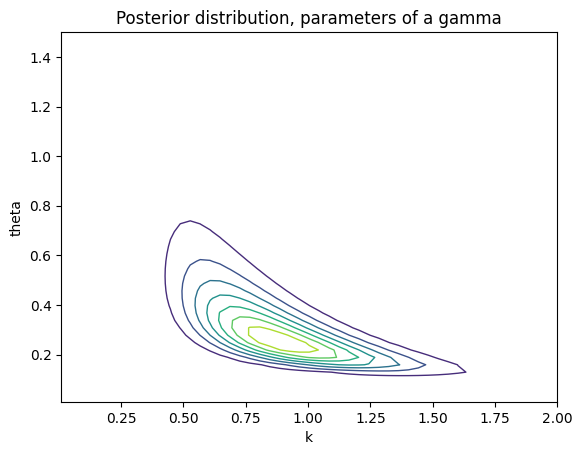

In [88]:
plot_contour(posterior)
plt.title('Posterior distribution, parameters of a gamma')
plt.xlabel('k')
plt.ylabel('theta')

In [89]:
# Check the marginals to make sure the range of the priors is wide enough

posterior_k = marginal(posterior, 0)
posterior_theta = marginal(posterior, 1)

<Axes: title={'center': 'Marginal posterior distribution of gamma parameter k'}, xlabel='k', ylabel='PDF'>

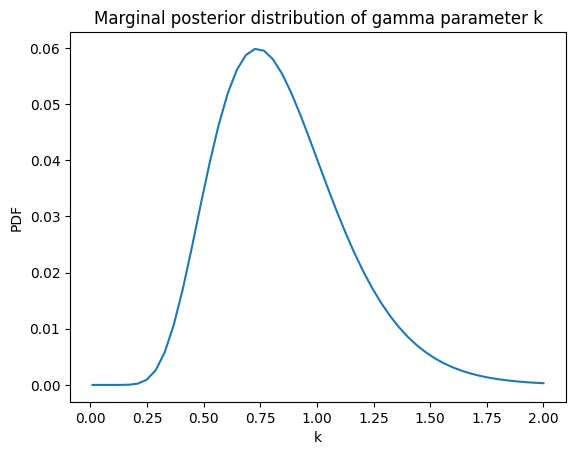

In [91]:
posterior_k.plot(title='Marginal posterior distribution of gamma parameter k', xlabel='k', ylabel='PDF')

<Axes: title={'center': 'Marginal posterior distribution of gamma parameter theta'}, xlabel='theta', ylabel='PDF'>

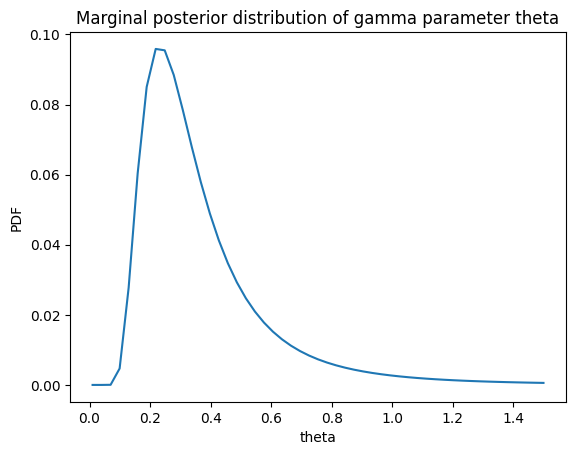

In [92]:
posterior_theta.plot(title='Marginal posterior distribution of gamma parameter theta', xlabel='theta', ylabel='PDF')

In [93]:
# To compute the posterior predictive distribution, stack the posterior to make a Series with a MultiIndex

posterior_series = posterior.stack()
posterior_series.head()

0.01  0.0100    4.306265e-156
      0.0498    1.304069e-145
      0.0896    2.463890e-141
      0.1294    2.077828e-138
      0.1692    4.227218e-136
dtype: float64

In [94]:
# Extend the predictive distribution up to 2 inches

low, high = 0.01, 2

In [95]:
def pmf_from_dist(dist, low, high):
    """Make a discrete approximation of a continuous distribution.
    
    dist: SciPy dist object
    low: low end of range
    high: high end of range
    
    returns: normalized Pmf
    """
    qs = np.linspace(low, high, 101)
    ps = dist.pdf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

In [96]:
qs = np.linspace(low, high, num=101)
pmf_seq = []
for (theta, k) in posterior_series.index:
    dist = gamma_dist(k, theta)
    pmf = pmf_from_dist(dist, qs) # This line throws an error. pmf_from_dist takes 3 arguments
    pmf_seq.append(pmf)
    
post_pred = make_mixture(posterior_series, pmf_seq)

# Unfortunately the error breaks the solution

TypeError: pmf_from_dist() missing 1 required positional argument: 'high'

In [ ]:
# If the commands above had worked,

cdf = post_pred.make_cdf()
p_gt = 1 - cdf(1.5)
# p_gt ~= 0.009
# 1 / p_gt ~= 111 days between rare rain events